In [1]:
# ==================================================================================
# ===>>> ****** Require cvxpy 0.4.9 ***** Higher version will not work ****** <<<===
# ===>>> ****** Require cvxpy 0.4.9 ***** Higher version will not work ****** <<<===
# ===>>> ****** Require cvxpy 0.4.9 ***** Higher version will not work ****** <<<===
# ==================================================================================

# Generate data for SVM classifier with L1 regularization

from __future__ import division
import numpy as np
from sklearn.metrics import confusion_matrix
np.random.seed(1)
n = 20
m = 20000
TEST = m
DENSITY = 0.2
beta_true = np.random.randn(n,1)
idxs = np.random.choice(range(n), int((1-DENSITY)*n), replace=False)
for idx in idxs:
    beta_true[idx] = 0
offset = 0
sigma = 0.2
X1 = np.random.normal(-0.3, 0.1, size=(int(m*0.005),n))
X2 = np.random.normal(0.3, 0.1, size=(int(m*0.995),n))
X = np.concatenate((X1, X2))
Y = np.sign(X.dot(beta_true) + offset + np.random.normal(0,sigma,size=(m,1)))

In [2]:
# ====================================================================
# Standard SVM Formulation
# ====================================================================

# Form SVM with L1 regularization problem

from cvxpy import *
beta = Variable(n)
v = Variable()
loss = sum_entries(pos(1 - mul_elemwise(Y, X*beta - v)))
reg = norm(beta, 1)
lambd = Parameter(sign="positive")
prob = Problem(Minimize(loss/m + lambd*reg))

In [3]:
# Confusion matrix for small lambda

lambd.value=0.0001
prob.solve()
Y_pred = np.sign(X.dot(beta.value) - v.value)
print(confusion_matrix(Y, Y_pred))

[[19653     0]
 [  247   100]]


In [4]:
# Confusion matrix for "large" lambda

lambd.value=0.1
prob.solve()
Y_pred = np.sign(X.dot(beta.value) - v.value)
print(confusion_matrix(Y, Y_pred))

[[19653     0]
 [  347     0]]


In [5]:
# Compute a trade-off curve and record train error.

TRIALS = 30
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-5, 0, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
#     Y_pred = np.sign(X.dot(beta.value) - v.value)
#     print(confusion_matrix(Y, Y_pred))
    train_error[i] = (np.sign(X.dot(beta_true) + offset) != np.sign(X.dot(beta.value) - v.value)).sum()/m
    beta_vals.append(beta.value)

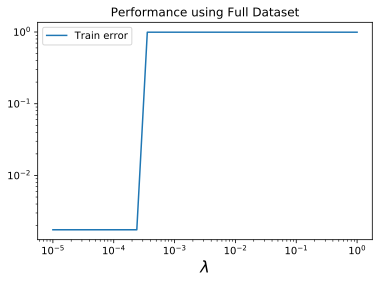

In [76]:
# Plot the train error over the trade-off curve.

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.semilogy(lambda_vals, train_error, label="Train error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.title('Performance using Full Dataset')
plt.savefig('error_full',bbox_inches='tight')

In [67]:
# ====================================================================
# New SVM Formulation from HW 2
# ====================================================================

# Prepare data input

pos_idx = np.where(Y==1)[0]
neg_idx = np.where(Y==-1)[0]

X_pos = X[pos_idx,:]
Y_pos = Y[pos_idx]

X_neg = X[neg_idx,:]
Y_neg = Y[neg_idx]

neg_mean = np.mean(X_neg,0)
neg_cov = np.cov((X_neg-neg_mean).T)
ch_fac = np.linalg.cholesky(neg_cov)

In [68]:
# Form SVM with L1 regularization problem.

import cvxpy
from cvxpy import *
from sklearn.metrics import confusion_matrix

w = Variable(n)
b = Variable()

loss1 = sum_entries(pos(1 - mul_elemwise(Y_pos, X_pos*w + b)))/m
loss2 = 0.5*(1 + neg_mean*w + b)
loss3 = 0.5*norm(cvxpy.vstack([ch_fac.T*w, 1 + b + neg_mean*w]),2)
reg = norm(w, 1)
lambd = Parameter(sign="positive")
prob = Problem(Minimize(loss1 + loss2 + loss3 + lambd*reg))

In [69]:
# Compute a trade-off curve and record train and test error.

from sklearn.metrics import confusion_matrix

TRIALS = 30
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-5, 0, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
    train_error[i] = (np.sign(X.dot(beta_true) + offset) != np.sign(X.dot(w.value) - b.value)).sum()/m
    beta_vals.append(w.value)

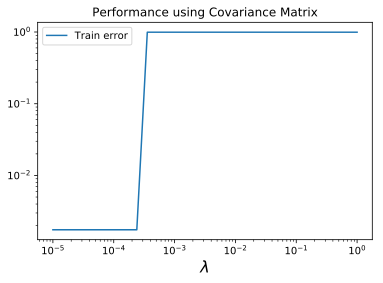

In [75]:
# Plot the train and test error over the trade-off curve.

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.semilogy(lambda_vals, train_error, label="Train error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.title('Performance using Covariance Matrix')
plt.savefig('error_cov',bbox_inches='tight')